In [1]:
from pinntorch import *
from functools import partial
from matplotlib.animation import FuncAnimation

In [2]:
K = 5.0

In [56]:
def exact_solution_log(x):
    return 1/(1+torch.exp(-torch.Tensor(K*x)))

# exact solution in NumPy: This one is needed for the loss function becasue somehow the tensor form does not work as of now.
def exact_solution_log_np(x):
    return 1/(1+np.exp(-K*x))

def create_noisy_data(x, std_dev, noise_seed = 42):
    exact = exact_solution_log(x)
    torch.manual_seed(noise_seed)

    return exact + torch.randn(exact.size())*std_dev 

def data_loss(model: PINN, data: torch.Tensor = None, x: torch.Tensor = None) -> torch.float:
    # MSE loss 
    return (f(model, x) - data).pow(2).mean()

def physics_loss(model: PINN, x: torch.Tensor = None) -> torch.float:
    # define PDE loss
    pde_loss_pre = df(model, x) - K*f(model, x)*(1 - f(model, x))
    pde_loss = pde_loss_pre.pow(2).mean()
    
    # define conditional losses (initial + boundary)
    boundary_loss_right_pre = (f(model, at(+1.0)) - exact_solution_log_np(+1)) 
    boundary_loss_right = boundary_loss_right_pre.pow(2).mean()

    # combine all losses
    final_loss = pde_loss + boundary_loss_right
    
    return final_loss


def total_loss(model: PINN, data: torch.Tensor = None, x: torch.Tensor= None, alpha: torch.float= None) -> list:

    """adds the physics and the data loss with coefficients alpha and (1-alpha) respectively"""

    loss_data = data_loss(model,data, x)

    loss_physics = physics_loss(model, x)

    return alpha*loss_data + (1 - alpha)*loss_physics

def custom_color_normalize(value):
    return value**80
    

def find_last_threshold_index(physics, validation, threshold = 0.0):
    over = (validation - physics) > threshold
    reversed_arr = np.flipud(over)
    index = len(over) - np.where(reversed_arr == False)[0][0] - 1
    return index

def get_best_indices(physics, validation, threshold = 0.0):
    best_indices = []
    for i in range(len(physics)):
        best_indices.append(find_last_threshold_index(physics[i], validation[i], threshold))
    return best_indices

In [67]:
settings = {}

settings['n_train_points'] = 20
settings['n_val_points'] = 39
settings['noise_level'] = 0.0#0.1
settings['noise_seed'] = 123
settings['start_learning_rate'] = 0.01

training_points = generate_grid((settings['n_train_points']), (-1.0,1.0))
validation_points = generate_grid((settings['n_val_points']), (-1.0,1.0))

data_noise = create_noisy_data(training_points, settings['noise_level'], noise_seed=settings['noise_seed'])

In [68]:
def train(train_points, data):

    # physics
    #loss_fn = partial(physics_loss, x=train_points) 
             
    # data
    loss_fn = partial(data_loss, data=data, x=train_points)

    # both
    #loss_fn = partial(total_loss, data=data, x=train_points, alpha=0.99)

    torch.manual_seed(12)
    model = PINN(1, 3, 9, 1)
    callbacks = [SolutionModelMonitor()]
    
    trained_model = train_model(
        model = model, 
        loss_fn=loss_fn,
        max_epochs = 10000,
        lr_decay=1e-2,
        optimizer_fn = partial(torch.optim.Adam, lr=settings['start_learning_rate']),
        epoch_callbacks = callbacks
    )
    return callbacks

In [69]:
callback = train(training_points, data_noise)

epoch: 1000	log10(loss sum): -6.3196	execution time (past 1k epochs): 2.4520
epoch: 2000	log10(loss sum): -7.0390	execution time (past 1k epochs): 2.4018
epoch: 3000	log10(loss sum): -7.1284	execution time (past 1k epochs): 2.3223
epoch: 4000	log10(loss sum): -7.2167	execution time (past 1k epochs): 2.5175
epoch: 5000	log10(loss sum): -7.2956	execution time (past 1k epochs): 2.3606
epoch: 6000	log10(loss sum): -7.3275	execution time (past 1k epochs): 2.3371
epoch: 7000	log10(loss sum): -7.3284	execution time (past 1k epochs): 2.2102
epoch: 8000	log10(loss sum): -7.3284	execution time (past 1k epochs): 2.1480
epoch: 9000	log10(loss sum): -7.3284	execution time (past 1k epochs): 2.2335


In [70]:
path = create_run_folder("data_no_noise")
save_list_of_model_states(path, callback[0].model_states)

In [71]:
plot_points = generate_grid(200, (-1.0, 1.0))
plot_points_np = plot_points.detach().cpu().numpy()
train_points_np = training_points.detach().cpu().numpy()

def plot_function(model, idx, save_fig=False):
    with torch.no_grad():
        train_func_values = f(model, training_points)
        # Evaluate the model (replace f(model, plot_points) with your specific function call)
        function_values = f(model, plot_points)

        
        # Reshape and convert function values to NumPy array
        #function_values_np = function_values.detach().cpu().numpy()

        # Plot the function and potentially save the figure
        plt.plot(plot_points_np, exact_solution_log_np(plot_points_np), linestyle=':', label='analytic')
        plt.plot(plot_points_np, function_values, label='model')
        plt.scatter(train_points_np, train_func_values, marker='.', label='train points')
        plt.scatter(train_points_np, data_noise, marker='x', label='data')
        plt.legend(loc='upper left')
        plt.xlabel('$t$')
        plt.ylabel('$u(t)$')
        plt.ylim(-0.05, 1.05)
        plt.title(f'Just Data (No Noise), Solution (Epoch {idx})')

MovieWriter ffmpeg unavailable; using Pillow instead.


0
0
100
200
300
400
500
600
700
800
900


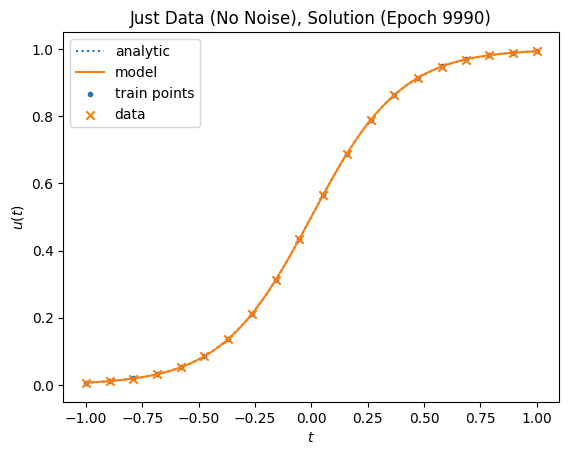

In [72]:

model = PINN(1, 3, 9, 1)

def update(frame):
    plt.clf()  # clear the previous frame

    if frame % 100 == 0:
        print(frame)

    model.load_state_dict(callback[0].model_states[frame*10])
    plot_function(model, frame*10)

    
# set up the figure and axes
fig, ax = plt.subplots()
animation = FuncAnimation(fig, update, frames=1000, interval=10)

# save the animation as a GIF using 'ffmpeg'
animation.save('data_nonoise_solution_evolution.gif', writer='ffmpeg', fps=30)

plt.show()